In [29]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import json

# Modelos Tradicionais (Baseline)
# 📊ARIMA
#### 💾 Carregamento e preparação da série temporal

In [30]:
df_cp = pd.read_parquet('../datasets/consumo_eredes_normalizado_4610.parquet') # Lê o ficheiro .parquet com os dados normalizados para o código postal 4610

static_feats = df_cp[["ZipCode","PopulationDensity"]].drop_duplicates() # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp, id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

#### 🧪 Separação treino / teste

In [31]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 (Opcional) Carregar um modelo existente

In [32]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/ARIMA/modelo/"
predictor_arima = TimeSeriesPredictor.load("../predicts/ARIMA/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA\modelo


#### 🛠️ Treinar ARIMA puro (sem covariáveis)

In [33]:
# Treina um modelo ARIMA com ordem (1,1,1) e sazonalidade diária (24 horas)
# Usa normalização dos dados com "standard scaler" e ignora a seleção automática de modelos/ensembles

predictor_arima = TimeSeriesPredictor(
    target="EnergyNormalized",       # Variável alvo a prever
    prediction_length=24,            # Previsão para as próximas 24 horas
    freq="h",                        # Frequência dos dados (horária)
    path="../predicts/ARIMA/modelo"  # Caminho onde o modelo será guardado
).fit(
    train_data,                      # Dados de treino
    tuning_data=test_data,           # Dados de validação (hold-out de 24h)
    hyperparameters={
        "ARIMAModel": {
            "order": (1, 1, 1),              # Parâmetros do modelo ARIMA (p, d, q)
            "seasonal_order": (1, 0, 1, 24), # Sazonalidade (P, D, Q, s), com s=24h
            "target_scaler": "standard",    # Normalização padrão dos valores do target
        }
    },
    time_limit=300,                 # Tempo máximo de treino (em segundos)
    presets="medium_quality",      # Conjunto de configurações predefinidas (qualidade média)
    skip_model_selection=True      # Ignora ensembles e força uso exclusivo do ARIMA
)

predictor_arima.save() # Guarda o modelo treinado no disco para reutilização futura (evita re-treinar)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       2.28 GB / 7.88 GB (28.9%)
Disk Space Avail:   872.27 GB / 931.51 GB (93.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'ARIMAModel': {'order': (1, 1, 1),
                                    'seasonal_order': (1, 0, 1, 24),
                                    'target_scaler': 'standard'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 

#### 🔮 Previsão com os dados de treino

In [34]:
# Gera previsões futuras com base nos dados de treino
future_preds = predictor_arima.predict(train_data) # O modelo irá prever os próximos 24 valores (horas) para cada série temporal presente em train_data
y_pred = future_preds["0.5"] # Extrai a previsão pontual (mediana das previsões probabilísticas, ou quantil 0.5)
y_pred = y_pred.droplevel(0) # Remove o primeiro nível do índice (que normalmente representa o ID da série, ex: código postal). Isso simplifica a estrutura do índice para facilitar visualização ou análise

Model not specified in predict, will default to the model with the best validation score: ARIMA


#### ✅ Preparar dados reais para comparação

In [35]:
# Cria uma máscara para filtrar os dados reais do código postal 4610. Apenas para o dia 30/09/2023 entre 00:00 e 23:00 (24 horas)
mask = (
    (df_cp["ZipCode"] == "4610") &
    (df_cp["DateTime"].between("2023-09-30 00:00", "2023-09-30 23:00"))
)

# Aplica a máscara ao DataFrame e seleciona apenas as colunas de interesse. Define "DateTime" como índice para facilitar a comparação com as previsões
df_true = df_cp.loc[mask, ["DateTime", "EnergyNormalized"]] \
               .set_index("DateTime")

y_true = df_true["EnergyNormalized"] # Extrai a série com os valores reais de consumo energético normalizado

#### 📊  Avaliação do modelo

In [36]:
metrics = predictor_arima.evaluate(test_data) # Avalia o desempenho do modelo ARIMA utilizando as métricas internas do AutoGluon

# Calcula métricas personalizadas de erro e desempenho entre os valores reais (y_true) e as previsões (y_pred)
mae  = mean_absolute_error(y_true, y_pred)               # Erro absoluto médio (MAE)
mse  = mean_squared_error(y_true, y_pred)                # Erro quadrático médio (MSE)
rmse = mse**0.5                                           # Raiz do erro quadrático médio (RMSE)
mape = (abs((y_true - y_pred) / y_true) * 100).mean()     # Erro percentual absoluto médio (MAPE)
r2 = r2_score(y_true, y_pred)                             # Coeficiente de determinação (R²)

# Agrupa as métricas personalizadas num dicionário
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²":    r2
}

# Exporta as métricas calculadas para um ficheiro JSON, para documentação ou análise posterior
with open("../predicts/ARIMA/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# Imprime os valores das métricas no terminal, com 5 casas decimais
print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²: {r2:.5f}")

Model not specified in predict, will default to the model with the best validation score: ARIMA


MAE:  0.02499
MSE:  0.00097
RMSE: 0.03117
MAPE: 47.82159%
R²: -15.00898


### 📊 **Métricas de Avaliação**

| Métrica                                     | Valor   | Interpretação                                                                                                                                                                                                             |
|---------------------------------------------|---------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)               | 0.02499 | Em média, o modelo errou cerca de 0.025 unidades de consumo normalizado por hora. Embora o valor possa parecer pequeno, o gráfico indica que o erro é mais significativo durante os picos de consumo. |
| **MSE** (Erro Quadrático Médio)             | 0.00097 | O valor do erro quadrático médio mostra que há penalizações maiores quando ocorrem erros grandes (como nos picos). Este valor, apesar de pequeno, indica que o modelo teve dificuldade em captar variações mais abruptas. |
| **RMSE** (Raiz do Erro Quadrático Médio)    | 0.03117 | O modelo tem um erro médio de cerca de 0.031 unidades de consumo, o que reforça a dificuldade em prever os padrões reais, principalmente os picos.                                                                        |
| **MAPE** (Erro Percentual Absoluto Médio)   | 47.82%  | O modelo erra em média quase 48% em relação ao valor real — um valor elevado, o que indica que o ARIMA, sem covariáveis, não é suficientemente preciso para capturar a dinâmica do consumo neste caso.                   |
| **R²**   | -15.00898  | O modelo é muito pior que a média. Não está a prever nada útil.                                                                                                                                                           |

#### 📈 Visualização dos resultados

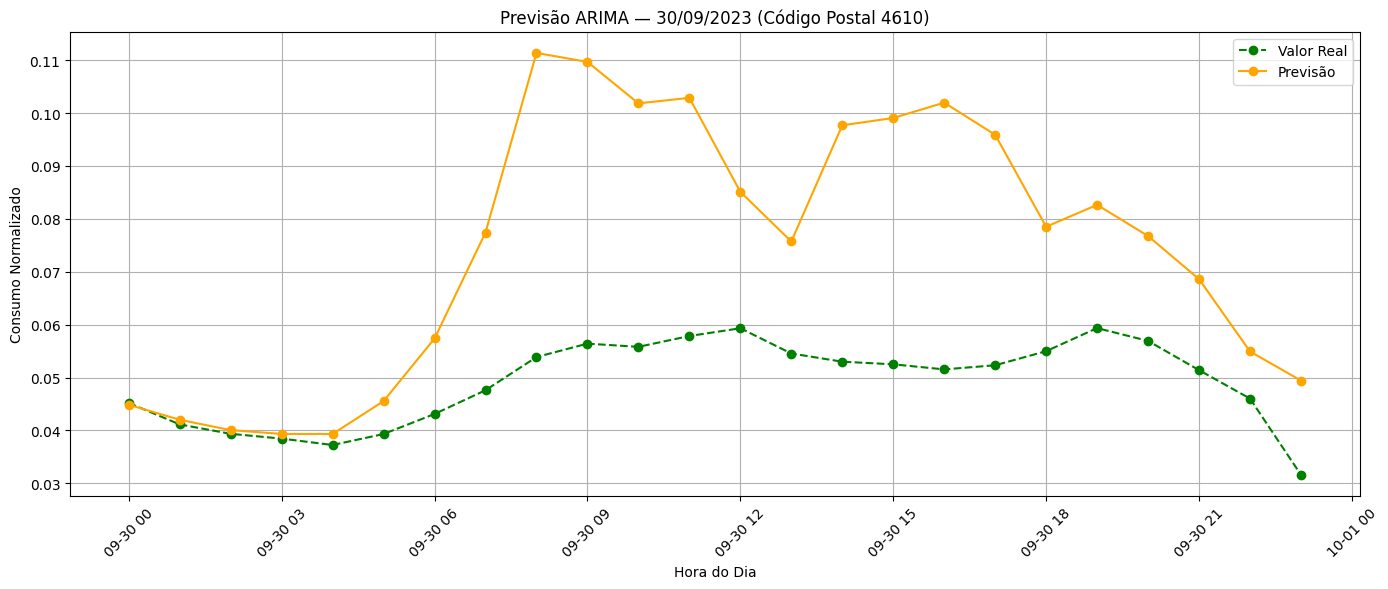

In [37]:
timestamps = future_preds.index.get_level_values("timestamp") # Obtém os timestamps (horas) da previsão a partir do índice multi-nível do DataFrame future_preds

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green') # Plota os valores reais com marcador e linha tracejada verde
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange') # Plota as previsões do modelo com marcador e linha contínua laranja

# Define o rótulo dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor legibilidade
plt.grid(True) # Adiciona grelha ao gráfico
plt.title("Previsão ARIMA — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir linha real vs prevista
plt.tight_layout() # Ajusta automaticamente os elementos do gráfico para caberem bem
plt.savefig("../predicts/ARIMA/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/ARIMA'
plt.show() # Exibe o gráfico